In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.6.0


## Hyperparameters

In [14]:
seq_len = 128

## Load IBM price and volume data

In [16]:
IBM_path = '/content/drive/My Drive/Transformer_Stock/IBM_data.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,7.713333,7.713333,7.626667,7.626667,390000
1,1962-01-03,7.626667,7.693333,7.626667,7.693333,292500
2,1962-01-04,7.693333,7.693333,7.613333,7.616667,262500
3,1962-01-05,7.606667,7.606667,7.453333,7.466667,367500
4,1962-01-08,7.460000,7.460000,7.266667,7.326667,547500


## Plot daily IBM closing prices

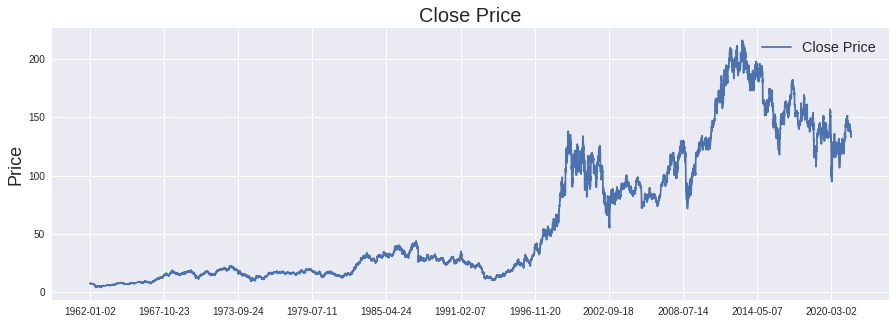

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Plot daily IBM volumes

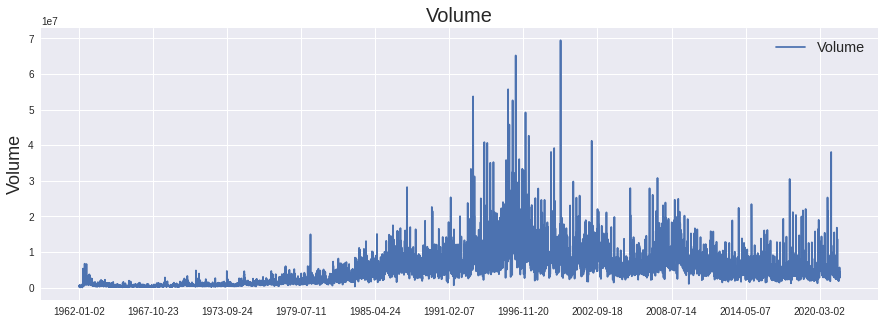

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Calculate normalized percentage change for all columns

In [19]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (12029, 5)
Validation data shape: (1504, 5)
Test data shape: (1503, 5)


,Open,High,Low,Close,Volume
1,0.564779,0.585893,0.592227,0.613581,0.029311
2,0.613581,0.592227,0.587956,0.567883,0.035499
3,0.564707,0.564707,0.540887,0.544117,0.056595
4,0.545124,0.545124,0.531045,0.546422,0.060364
5,0.559480,0.607509,0.623604,0.621124,0.035780


## Plot daily changes of close prices and volume

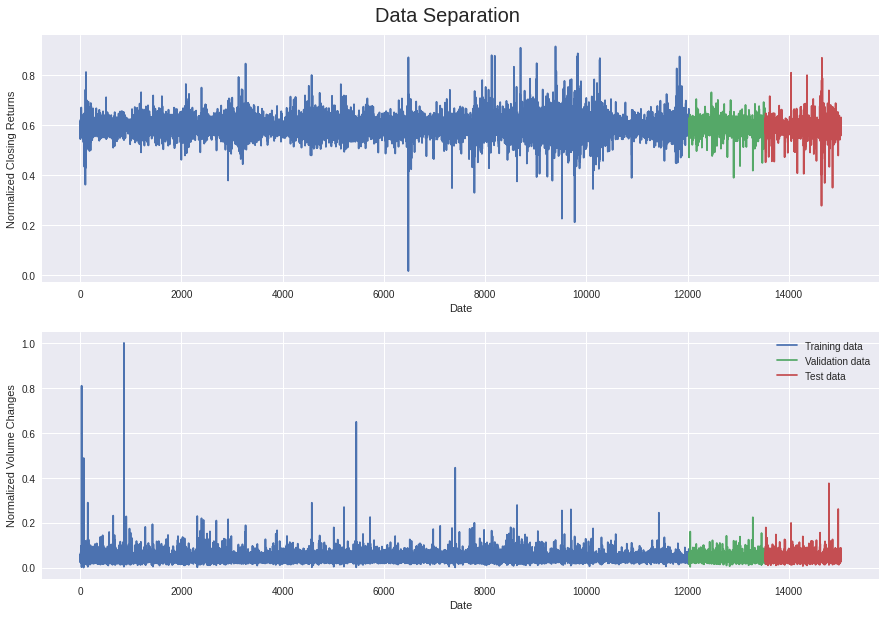

In [20]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create chunks of training, validation and test data

In [21]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11901, 128, 5) (11901,)
(1376, 128, 5) (1376,)


## 1D Convolution layers for a CNN+LSTM model

In [22]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

# **Testing different model architectures**

### Bi-LSTM model

In [23]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    


Epoch 1/200
6/6 - 23s - loss: 0.0547 - mae: 0.1733 - mape: 29.5885 - val_loss: 0.0091 - val_mae: 0.0911 - val_mape: 15.6705

Epoch 00001: val_loss improved from inf to 0.00914, saving model to Bi-LSTM.hdf5
Epoch 2/200
6/6 - 7s - loss: 0.0061 - mae: 0.0651 - mape: 11.2466 - val_loss: 0.0036 - val_mae: 0.0534 - val_mape: 9.2665

Epoch 00002: val_loss improved from 0.00914 to 0.00358, saving model to Bi-LSTM.hdf5
Epoch 3/200
6/6 - 7s - loss: 0.0030 - mae: 0.0436 - mape: 7.6637 - val_loss: 0.0027 - val_mae: 0.0452 - val_mape: 7.8539

Epoch 00003: val_loss improved from 0.00358 to 0.00271, saving model to Bi-LSTM.hdf5
Epoch 4/200
6/6 - 7s - loss: 0.0023 - mae: 0.0360 - mape: 6.3573 - val_loss: 0.0016 - val_mae: 0.0324 - val_mape: 5.6500

Epoch 00004: val_loss improved from 0.00271 to 0.00161, saving model to Bi-LSTM.hdf5
Epoch 5/200
6/6 - 7s - loss: 0.0019 - mae: 0.0319 - mape: 5.6732 - val_loss: 0.0013 - val_mae: 0.0280 - val_mape: 4.8779

Epoch 00005: val_loss improved from 0.00161 to 0.0

 
Evaluation metrics
Training Data - Loss: 0.0016, MAE: 0.0280, MAPE: 5.0253
Validation Data - Loss: 0.0009, MAE: 0.0210, MAPE: 3.5852
Test Data - Loss: 0.0016, MAE: 0.0252, MAPE: 4.3891


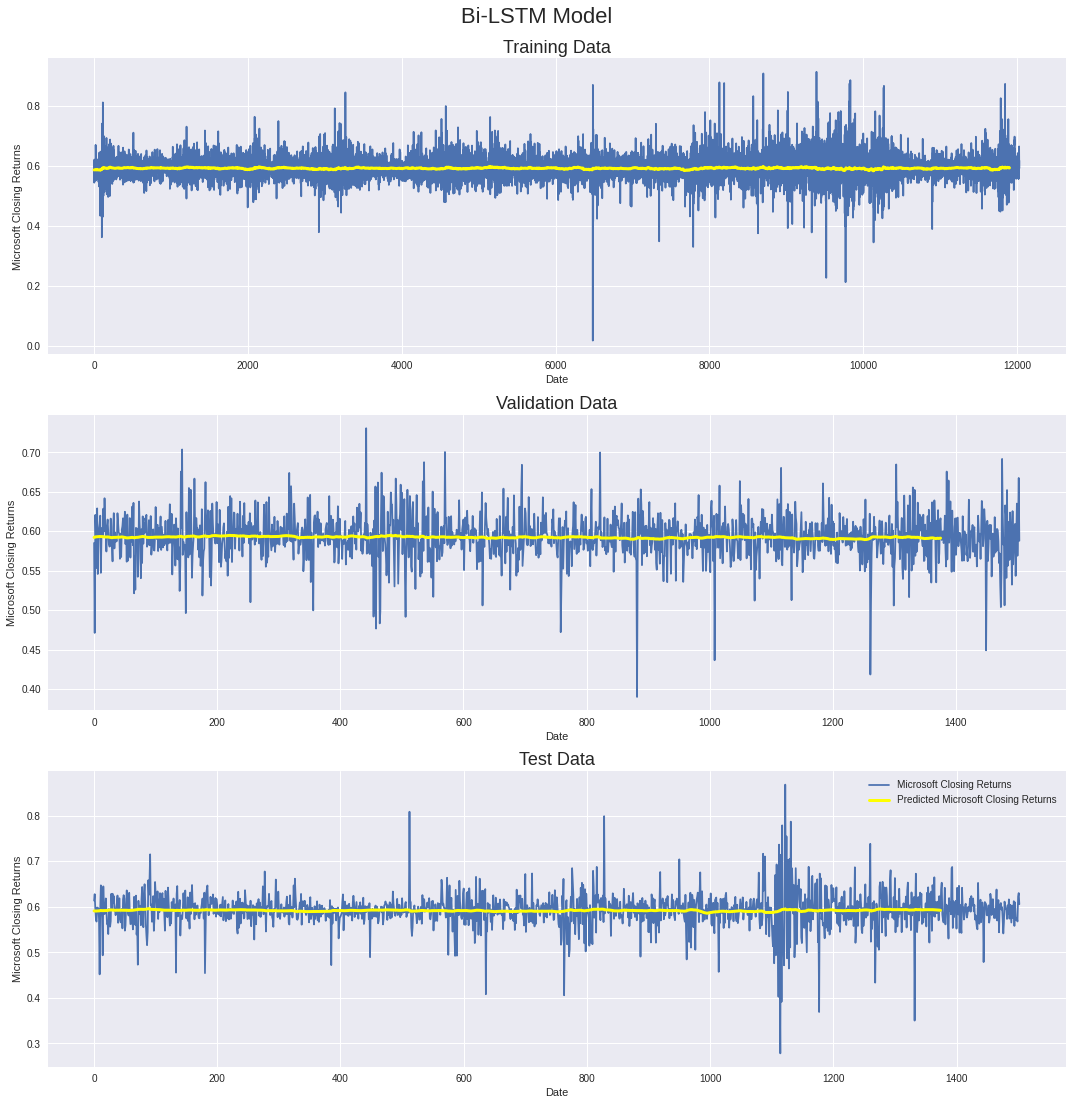

In [24]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')

plt.tight_layout()
plt.legend(loc='best')

### CNN + Bi-LSTM model

Epoch 1/200
6/6 - 58s - loss: 0.0053 - mae: 0.0580 - mape: 10.0125 - val_loss: 0.0064 - val_mae: 0.0754 - val_mape: 12.5603

Epoch 00001: val_loss improved from inf to 0.00640, saving model to CNN+Bi-LSTM.hdf5
Epoch 2/200
6/6 - 7s - loss: 0.0019 - mae: 0.0316 - mape: 5.6207 - val_loss: 0.0049 - val_mae: 0.0651 - val_mape: 10.8317

Epoch 00002: val_loss improved from 0.00640 to 0.00492, saving model to CNN+Bi-LSTM.hdf5
Epoch 3/200
6/6 - 7s - loss: 0.0017 - mae: 0.0300 - mape: 5.3832 - val_loss: 0.0043 - val_mae: 0.0606 - val_mape: 10.0659

Epoch 00003: val_loss improved from 0.00492 to 0.00434, saving model to CNN+Bi-LSTM.hdf5
Epoch 4/200
6/6 - 7s - loss: 0.0016 - mae: 0.0286 - mape: 5.1631 - val_loss: 0.0035 - val_mae: 0.0535 - val_mape: 8.8798

Epoch 00004: val_loss improved from 0.00434 to 0.00351, saving model to CNN+Bi-LSTM.hdf5
Epoch 5/200
6/6 - 7s - loss: 0.0016 - mae: 0.0283 - mape: 5.0819 - val_loss: 0.0026 - val_mae: 0.0443 - val_mape: 7.3422

Epoch 00005: val_loss improved fr

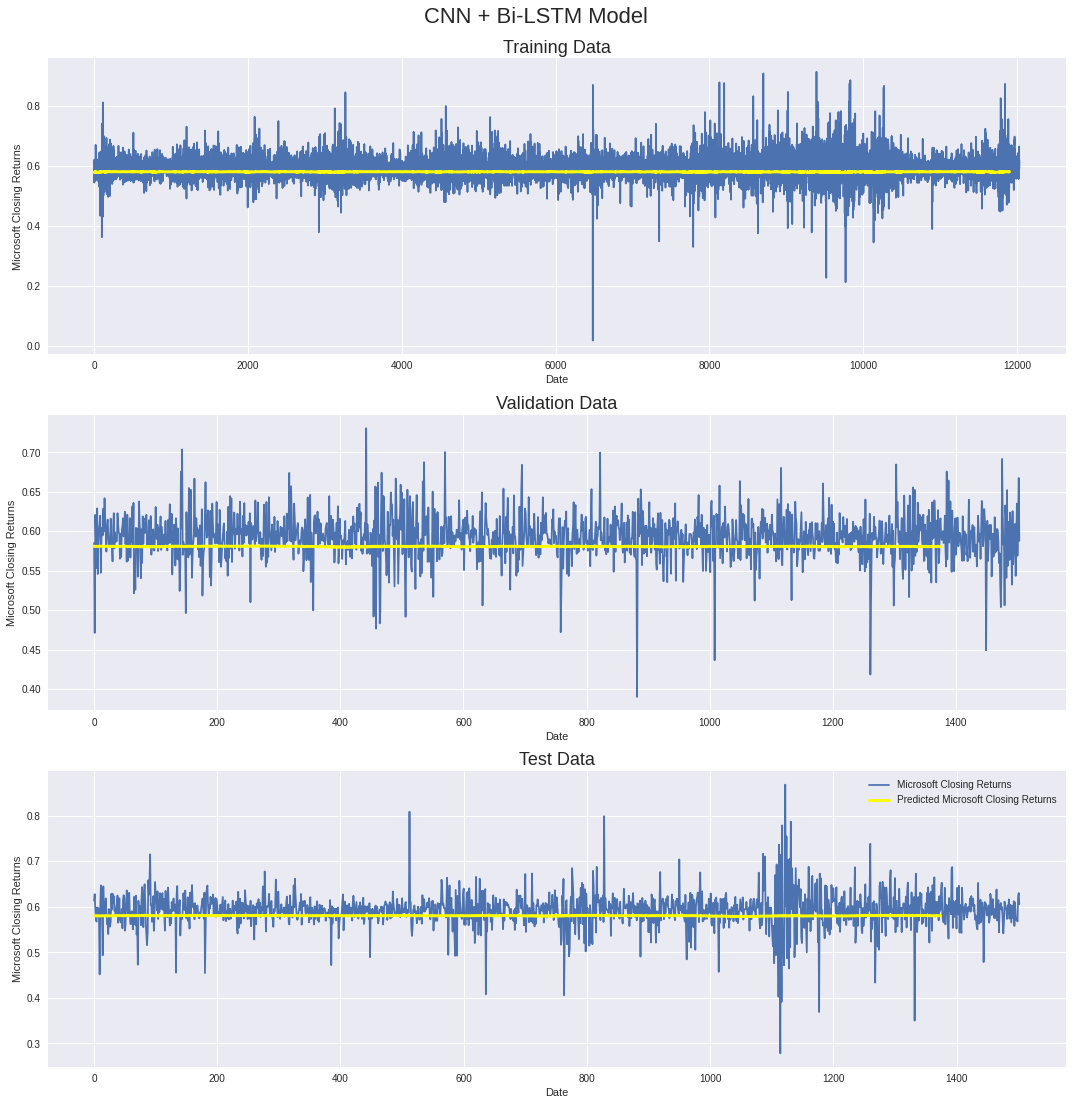

In [25]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

# **Moving Average Analysis**

## Loading IBM data again to apply a moving average effect

In [26]:
IBM_path = '/content/drive/MyDrive/Transformer_Stock/IBM_data.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

df.head()

,Date,Open,High,Low,Close,Volume
9,1962-01-15,7.540000,7.578333,7.488667,7.515000,367500.0
10,1962-01-16,7.523333,7.561667,7.473333,7.499667,354000.0
11,1962-01-17,7.504667,7.536333,7.444000,7.465667,366750.0
12,1962-01-18,7.472667,7.511667,7.420000,7.441333,378000.0
13,1962-01-19,7.449333,7.490333,7.404000,7.432667,381750.0


## Moving Average - Plot daily IBM closing prices

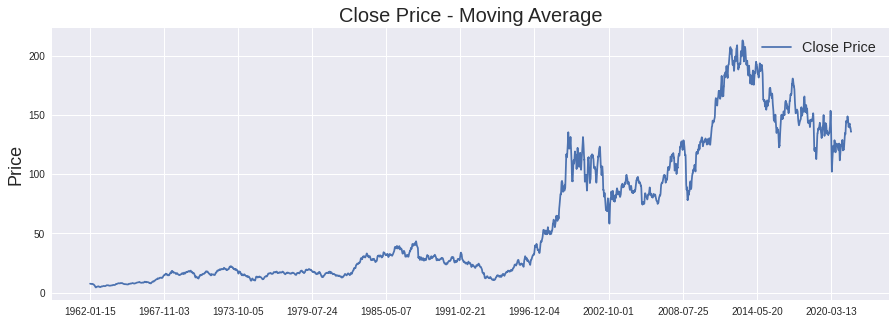

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Plot daily IBM volumes

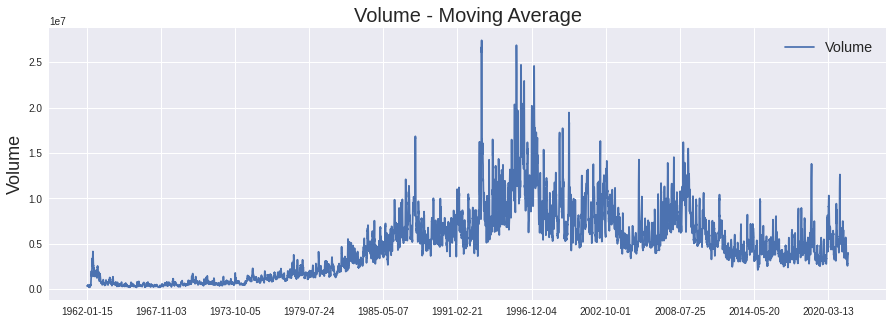

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [29]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (12022, 5)
Validation data shape: (1503, 5)
Test data shape: (1502, 5)


,Open,High,Low,Close,Volume
10,0.516547,0.516711,0.518941,0.519047,0.305563
11,0.512567,0.499793,0.491343,0.482399,0.362434
12,0.486361,0.500928,0.501647,0.501128,0.358258
13,0.503140,0.507292,0.517342,0.531919,0.342034
14,0.533253,0.547731,0.567569,0.556950,0.278991


## Moving Average - Plot daily changes of close prices and volume

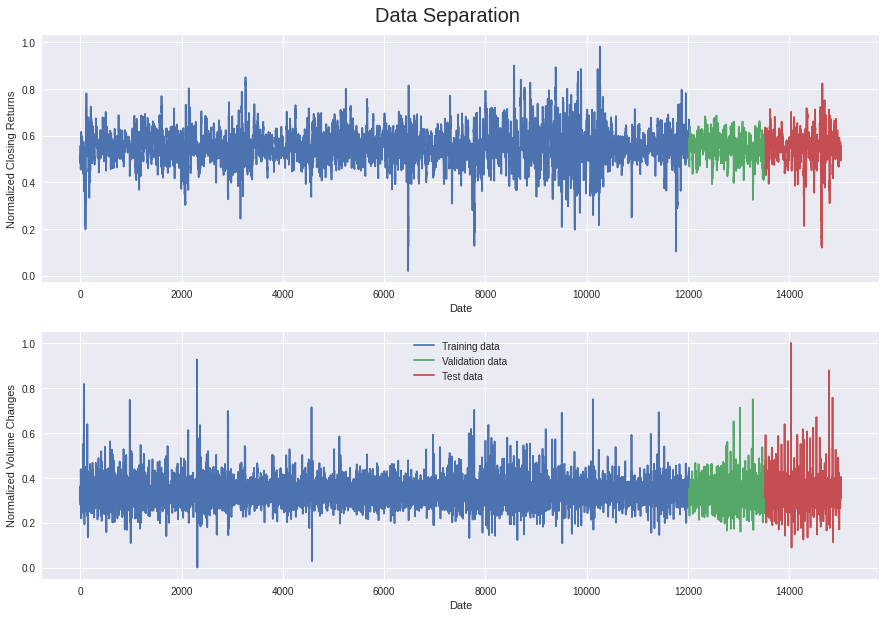

In [30]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Moving Average - Create chunks of training, validation and test data

In [31]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11894, 128, 5) (11894,)
(1375, 128, 5) (1375,)


# **Moving Average - Testing different model architectures**

### Moving Average - Bi-LSTM model

In [32]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

Epoch 1/200
6/6 - 20s - loss: 0.0063 - mae: 0.0601 - mape: 11.6450 - val_loss: 0.0027 - val_mae: 0.0403 - val_mape: 7.6736

Epoch 00001: val_loss improved from inf to 0.00265, saving model to Bi-LSTM.hdf5
Epoch 2/200
6/6 - 7s - loss: 0.0055 - mae: 0.0550 - mape: 10.7900 - val_loss: 0.0025 - val_mae: 0.0394 - val_mape: 7.4070

Epoch 00002: val_loss improved from 0.00265 to 0.00255, saving model to Bi-LSTM.hdf5
Epoch 3/200
6/6 - 7s - loss: 0.0054 - mae: 0.0546 - mape: 10.7243 - val_loss: 0.0025 - val_mae: 0.0392 - val_mape: 7.3720

Epoch 00003: val_loss improved from 0.00255 to 0.00253, saving model to Bi-LSTM.hdf5
Epoch 4/200
6/6 - 8s - loss: 0.0054 - mae: 0.0543 - mape: 10.6644 - val_loss: 0.0025 - val_mae: 0.0394 - val_mape: 7.4471

Epoch 00004: val_loss did not improve from 0.00253
Epoch 5/200
6/6 - 7s - loss: 0.0053 - mae: 0.0536 - mape: 10.5100 - val_loss: 0.0026 - val_mae: 0.0398 - val_mape: 7.5859

Epoch 00005: val_loss did not improve from 0.00253
Epoch 6/200
6/6 - 8s - loss: 0.

 
Evaluation metrics
Training Data - Loss: 0.0010, MAE: 0.0223, MAPE: 4.3500
Validation Data - Loss: 0.0005, MAE: 0.0172, MAPE: 3.1902
Test Data - Loss: 0.0009, MAE: 0.0207, MAPE: 4.1954


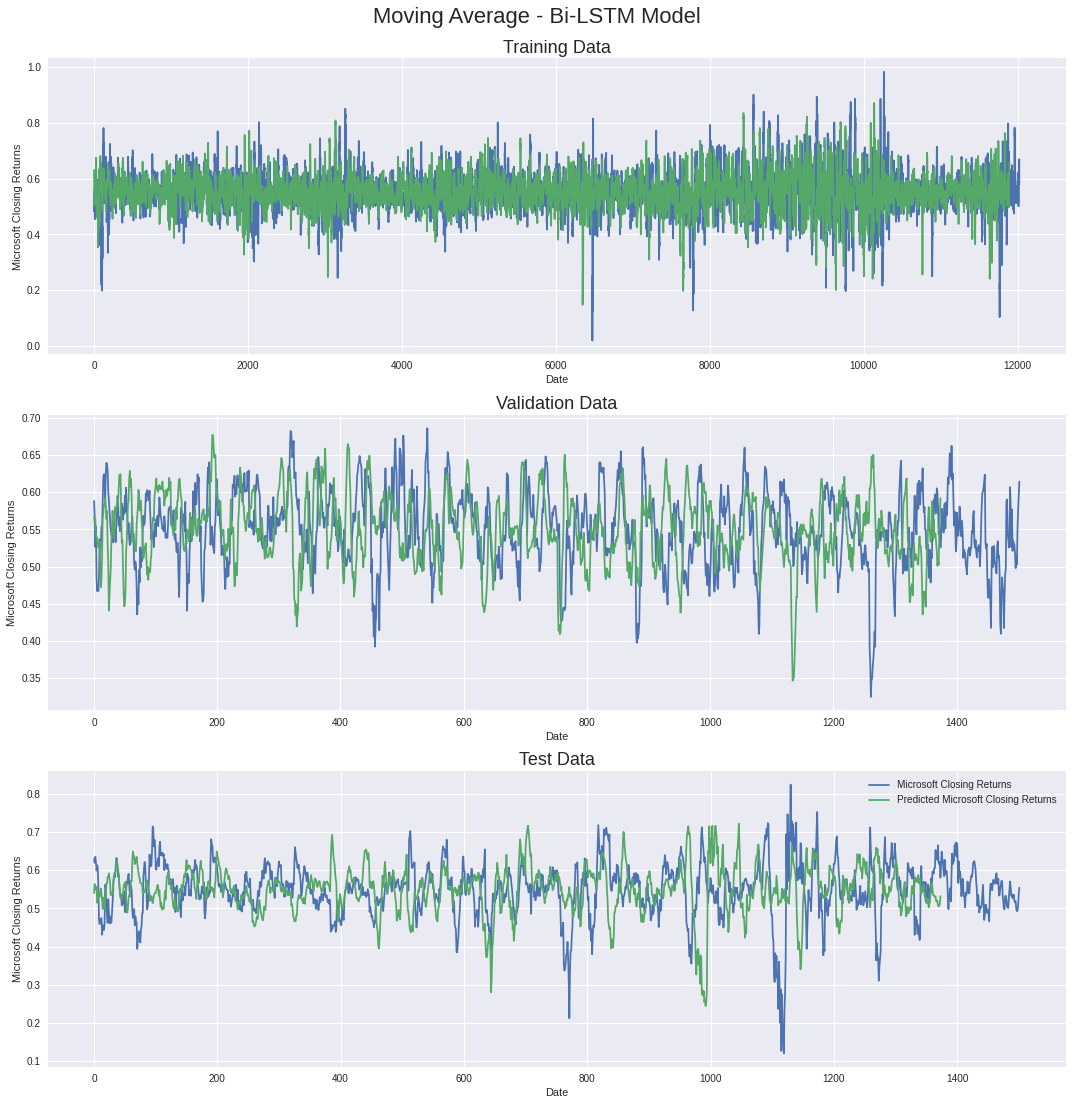

In [33]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

### Moving Average - CNN + Bi-LSTM model

Epoch 1/200
6/6 - 32s - loss: 0.0114 - mae: 0.0848 - mape: 16.1433 - val_loss: 0.0042 - val_mae: 0.0533 - val_mape: 9.4214

Epoch 00001: val_loss improved from inf to 0.00425, saving model to CNN+Bi-LSTM.hdf5
Epoch 2/200
6/6 - 7s - loss: 0.0059 - mae: 0.0577 - mape: 11.2733 - val_loss: 0.0040 - val_mae: 0.0511 - val_mape: 9.0600

Epoch 00002: val_loss improved from 0.00425 to 0.00396, saving model to CNN+Bi-LSTM.hdf5
Epoch 3/200
6/6 - 7s - loss: 0.0053 - mae: 0.0540 - mape: 10.7695 - val_loss: 0.0040 - val_mae: 0.0516 - val_mape: 9.1370

Epoch 00003: val_loss did not improve from 0.00396
Epoch 4/200
6/6 - 7s - loss: 0.0050 - mae: 0.0528 - mape: 10.3164 - val_loss: 0.0035 - val_mae: 0.0477 - val_mape: 8.4942

Epoch 00004: val_loss improved from 0.00396 to 0.00354, saving model to CNN+Bi-LSTM.hdf5
Epoch 5/200
6/6 - 7s - loss: 0.0045 - mae: 0.0496 - mape: 9.6973 - val_loss: 0.0032 - val_mae: 0.0451 - val_mape: 8.0772

Epoch 00005: val_loss improved from 0.00354 to 0.00323, saving model to

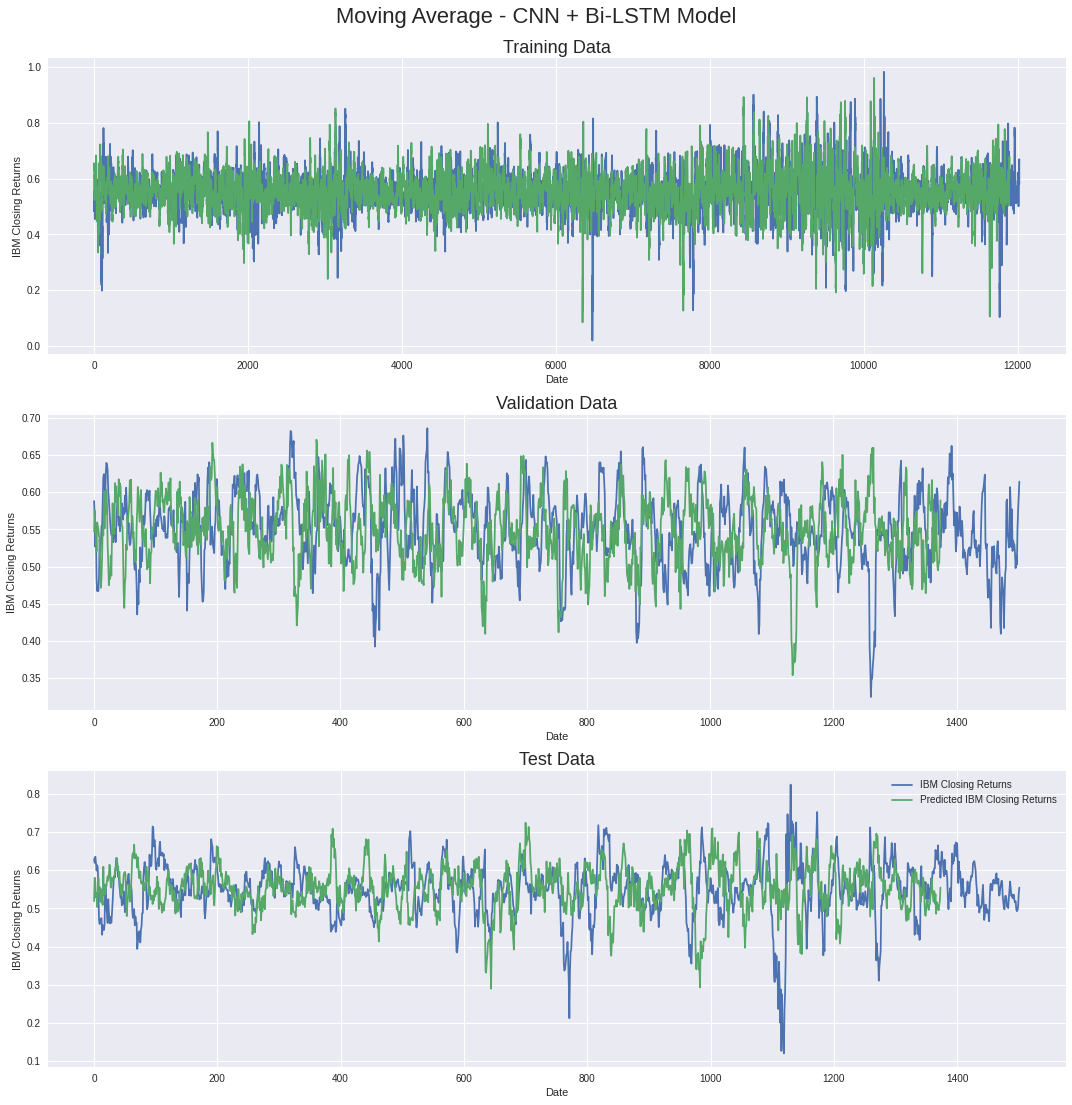

In [35]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

---
Sequential NN Results
---
##### **Bi-LSTM**
> Validation Data - Loss: 0.0009, MAE: 0.0210, MAPE: 3.5852

> Test Data - Loss: 0.0016, MAE: 0.0252, MAPE: 4.3891

##### **CNN+Bi-LSTM**

> Validation Data - Loss: 0.0010, MAE: 0.0234, MAPE: 3.9355

> Test Data - Loss: 0.0017, MAE: 0.0278, MAPE: 4.7458

---
Sequential NN + Moving Average Integrated Results
---

##### **Moving Average Bi-LSTM**
> Validation Data - Loss: 0.0005, MAE: 0.0172, MAPE: 3.1902

> Test Data - Loss: 0.0009, MAE: 0.0207, MAPE: 4.1954

##### **Moving Average CNN+Bi-LSTM**

> Validation Data - Loss: 0.0008, MAE: 0.0218, MAPE: 4.0254

> Test Data - Loss: 0.0016, MAE: 0.0284, MAPE: 5.8967

